In [54]:
import finesse
import finesse.analysis.actions as fac
import matplotlib.pylab as plt
import finesse.components as fc
import finesse.detectors as det
finesse.configure(plotting=True)
import numpy as np 

In [55]:
# In this notebook, we will solve the quiz1 from the Finesse workshop.

# TASK 1: Build a model similar to the example in the workshop, but with an EOM inserted before the cavity.

eom_model=finesse.Model()

LASER = eom_model.add(fc.Laser("LASER", P=1e-3,phase=0))

EOM= eom_model.add(fc.modulator.Modulator("EOM", mod_type="pm", midx=0.2, f=13e6, phase=0))

sLASER_EOM=eom_model.add(fc.Space('sLASER_EOM',portA=LASER.p1,portB=EOM.p1,L=1)) #L=0 by default


M1 = eom_model.add(fc.Mirror("M1", R=0.99, L=0))
sEOM_M1=eom_model.add(fc.Space('sEOM_M1',portA=EOM.p2,portB=M1.p1,L=1)) #L=0 by default
M2 = eom_model.add(fc.Mirror("M2", R=0.999, L=0))
sM1_M2=eom_model.add(fc.Space('sM1_M2',portA=M1.p2,portB=M2.p1,L=1))

# ADD the cavity command and the photodetector

eom_model.add(det.PowerDetector('pdinc', M1.p1.i)); # Incident power
eom_model.add(det.PowerDetector('pdrefl', M1.p1.o)); # Reflected power
eom_model.add(det.PowerDetector('pdtrans', M2.p2.o)); # transmitted power
eom_model.add(det.PowerDetector('pdcirc', M1.p2.i)); # Circulating power

# # now, this all was using planewaves. We can switch to Gaussian beams.
# # First, we need to assign radii of curvature to the mirrors.
eom_model.M1.Rc = -0.7  # Radius of curvature for M1 in meters
eom_model.M2.Rc = 0.7  # Radius of curvature for M2 in meters

eom_model.add(fc.Cavity('cavity', source=eom_model.M1.p2.o))



<'cavity' @ 0x15a39b6d0 (Cavity)>

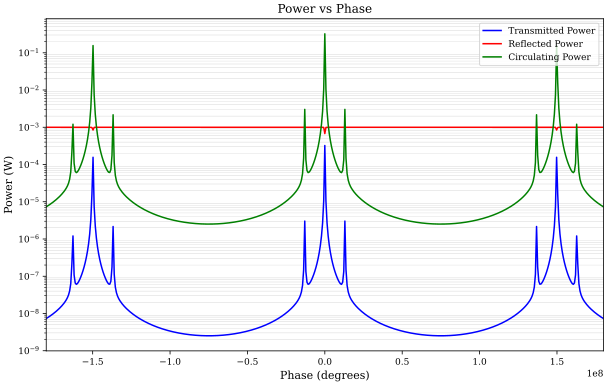

In [56]:
# TASK 2: Scan the laser's frequency, or the cavity's length, and see the sidebands in the spectrum.

out = eom_model.run(fac.Xaxis(LASER.f,'lin', -180e6, 180e6, 500))
x_axis=out.x1
pdtrans=out['pdtrans']
pdrefl=out['pdrefl']
pdcirc=out['pdcirc']    
# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogy(x_axis, pdtrans, label='Transmitted Power', color='blue')
plt.plot(x_axis, pdrefl, label='Reflected Power', color='red')
plt.plot(x_axis, pdcirc, label='Circulating Power', color='green')
plt.xlabel('Phase (degrees)')
plt.ylabel('Power (W)')
plt.title('Power vs Phase')
plt.legend()
plt.grid()
plt.show()

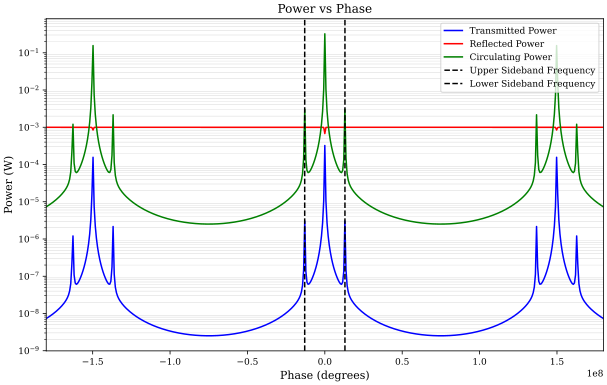

In [57]:
# TASK3
# Confirm that the sidebands are at the expected frequencies. You can add a vertical line at the expected frequency using the following command:
# plt.axvline(x=expected_frequency, color='r', linestyle='--', label='Expected Frequency of SB')



plt.figure(figsize=(10, 6))
plt.semilogy(x_axis, pdtrans, label='Transmitted Power', color='blue')
plt.plot(x_axis, pdrefl, label='Reflected Power', color='red')
plt.plot(x_axis, pdcirc, label='Circulating Power', color='green')
plt.axvline(x=eom_model.EOM.f, color='black', linestyle='--', label='Upper Sideband Frequency')
plt.axvline(x=-eom_model.EOM.f, color='black', linestyle='--', label='Lower Sideband Frequency')
plt.xlabel('Phase (degrees)')
plt.ylabel('Power (W)')
plt.title('Power vs Phase')
plt.legend()
plt.grid()
plt.show()

In [58]:
# Bonus Task: Add an amplitude detector and measure the power in the carrier and sidebands.
AD_carrier=eom_model.add(det.AmplitudeDetector('AD_carrier',f=0,n=0,m=0,node=eom_model.M2.p2.o))
AD_LSB=eom_model.add(det.AmplitudeDetector('AD_LSB',f=-eom_model.EOM.f,n=0,m=0,node=eom_model.M2.p2.o))
AD_USB=eom_model.add(det.AmplitudeDetector('AD_USB',f=eom_model.EOM.f,n=0,m=0,node=eom_model.M2.p2.o))


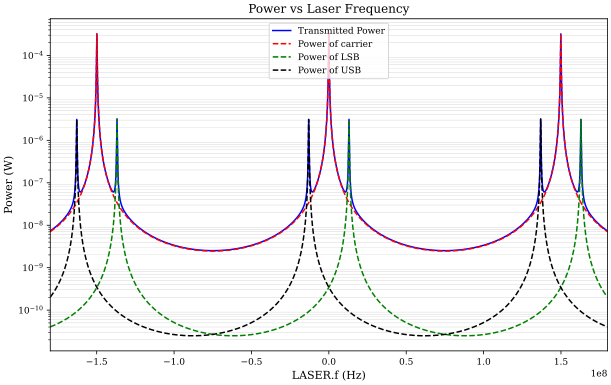

In [59]:
out = eom_model.run(fac.Xaxis(LASER.f,'lin', -180e6, 180e6, 5000))
x_axis=out.x1
pdtrans=out['pdtrans']
AD_carrier=out['AD_carrier']
AD_LSB=out['AD_LSB']  
AD_USB=out['AD_USB']    

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogy(x_axis, pdtrans, label='Transmitted Power', color='blue')
plt.plot(x_axis, np.abs(AD_carrier)**2 ,'--',label='Power of carrier', color='red')
plt.plot(x_axis, np.abs(AD_LSB)**2, '--',label='Power of LSB', color='green')
plt.plot(x_axis, np.abs(AD_USB)**2, '--',label='Power of USB', color='black')

plt.xlabel('LASER.f (Hz)')
plt.ylabel('Power (W)')
plt.title('Power vs Laser Frequency')
plt.legend()
plt.grid()
plt.show()

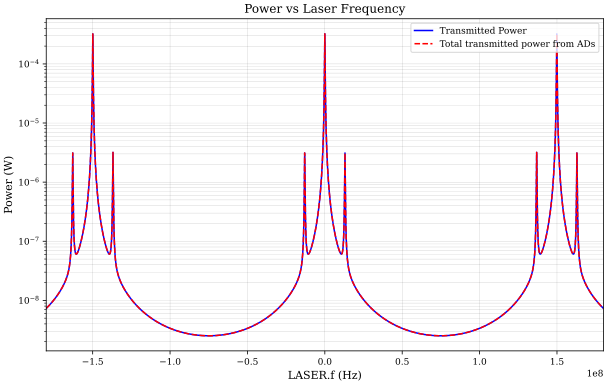

In [60]:
#OR let's calculate the total transmitted power through the amplitude detectors 
total_transmitted_power=np.abs(AD_carrier)**2+np.abs(AD_LSB)**2+np.abs(AD_USB)**2

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogy(x_axis, pdtrans, label='Transmitted Power', color='blue')
plt.plot(x_axis, total_transmitted_power ,'--',label='Total transmitted power from ADs', color='red')


plt.xlabel('LASER.f (Hz)')
plt.ylabel('Power (W)')
plt.title('Power vs Laser Frequency')
plt.legend()
plt.grid(True)
plt.show()

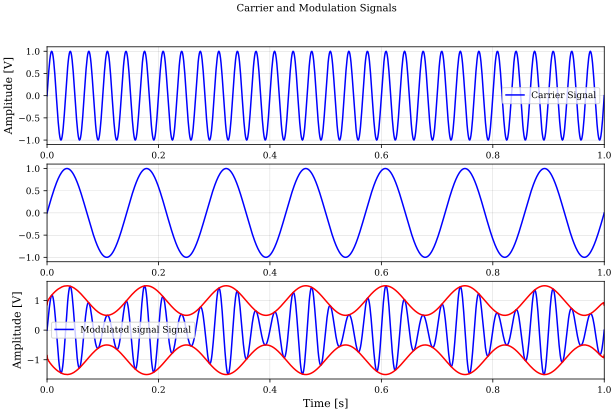

In [ ]:
#Now let's look at the PDH signal. 
#We need a demodulation photodiode on reflection 
#Before we do that, let's look at demodulation
from scipy.signal import hilbert
# Extracting the envelope using the Hilbert transform
f_c=30
f_m=7
m=0.5
t=np.linspace(0,1,1000)

carrier_signal=np.sin(2*np.pi*f_c*t)
modulation_signal=np.sin(2*np.pi*f_m*t)
a=carrier_signal*(1+m*modulation_signal)


analytic_signal = hilbert(modulated_signal)
envelope = np.abs(analytic_signal)

# envelope_signal=np.sin(2*np.pi*(f_c-f_m)*t)

fig , ax= plt.subplots(3,1,figsize=(10,6))
ax[0].plot(t,carrier_signal,label='Carrier Signal')
ax[0].set_ylabel("Amplitude [V]")
ax[0].legend()
ax[1].plot(t,modulation_signal,label='Modulation signal Signal')
ax[2].plot(t,modulated_signal,label='Modulated signal Signal')
ax[2].plot(t,envelope,c='r')
ax[2].plot(t,-envelope,c='r')

ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel("Amplitude [V]")
ax[2].legend()
plt.suptitle("Carrier and Modulation Signals")
plt.show()


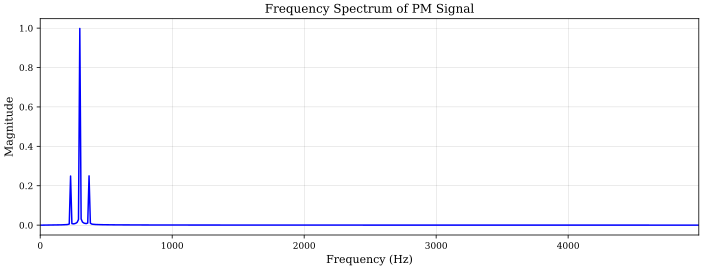

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 10000              # Sampling frequency (Hz)
duration = 1.0          # Duration in seconds
t = np.arange(0, duration, 1/fs)  # Time vector
f_c = 1000              # Carrier frequency (Hz)
f_m = 100               # Modulation frequency (Hz)
beta = 5.0              # Modulation index

# Modulation signal (e.g., sine wave)
modulation_signal = np.sin(2 * np.pi * f_m * t)

# PM Signal
pm_signal = np.sin(2 * np.pi * f_c * t + beta * modulation_signal)

# FFT
N = len(modulated_signal)
fft_result = np.fft.fft(modulated_signal)
fft_freqs = np.fft.fftfreq(N, 1/fs)

# Take only the positive frequencies
positive_freqs = fft_freqs[:N//2]
magnitude_spectrum = np.abs(fft_result)[:N//2] * 2 / N

# Plot
plt.figure(figsize=(10, 4))
plt.plot(positive_freqs, magnitude_spectrum)
plt.title("Frequency Spectrum of PM Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
# # Multiply by carrier again (coherent demodulation)
# demodulated = modulated_signal * carrier_signal

# # Apply low-pass filter to extract baseband signal
# from scipy.signal import butter, filtfilt

# # Design low-pass filter
# def lowpass_filter(data, cutoff, fs, order=4):
#     nyq = 0.5 * fs
#     norm_cutoff = cutoff / nyq
#     b, a = butter(order, norm_cutoff, btype='low', analog=False)
#     return filtfilt(b, a, data)

# fs = 1/(t[1]-t[0])  # Sampling rate 
# cutoff = 15  # Slightly above modulation frequency
# recovered_sync = lowpass_filter(demodulated, cutoff, fs)

# # Plot result
# plt.figure(figsize=(10,4))
# plt.plot(t, modulation_signal, label='Original Modulation Signal')
# plt.plot(t, recovered_sync , label='Recovered (Coherent)', linestyle='--')
# plt.xlabel("Time [s]")
# plt.ylabel("Amplitude")
# plt.title("Coherent Demodulation")
# plt.legend()
# plt.grid(True)
# plt.show()


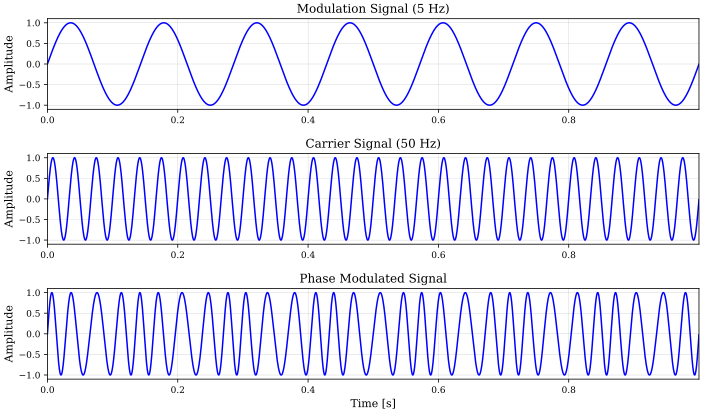

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 10000                     # Sampling frequency [Hz]
T = 1                          # Duration [s]
t = np.linspace(0, T, int(fs*T), endpoint=False)

f_c = 30                       # Carrier frequency [Hz]
f_m = 7                        # Modulation frequency [Hz]
beta = 1.0                     # Modulation index (phase deviation)

# Signals
modulation_signal = np.sin(2 * np.pi * f_m * t)
carrier = np.sin(2 * np.pi * f_c * t)

# Phase-modulated signal
pm_signal = np.sin(2 * np.pi * f_c * t + beta * modulation_signal)

# Plotting
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(t, modulation_signal)
plt.title("Modulation Signal (5 Hz)")
plt.ylabel("Amplitude")

plt.subplot(3,1,2)
plt.plot(t, carrier)
plt.title("Carrier Signal (50 Hz)")
plt.ylabel("Amplitude")

plt.subplot(3,1,3)
plt.plot(t, pm_signal)
plt.title("Phase Modulated Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [66]:
analytic_signal = hilbert(pm_signal)
phase_envelope = np.unwrap(np.angle(analytic_signal))


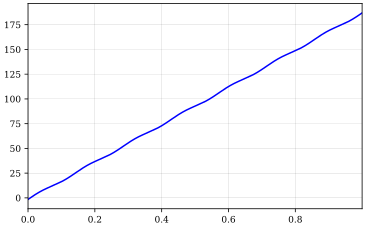

In [71]:
plt.plot(t,phase_envelope)
# plt.plot(t,np.gradient(phase_envelope))

In [64]:
#First, Let's look at the PDH signal 
#We need to add a PowerDetector that can demodulate the beam 
pdh_pd=eom_model.add(det.PowerDetectorDemod1("pdh_pd",node=eom_model.M1.p1.o,f=eom_model.EOM.f,phase=0))


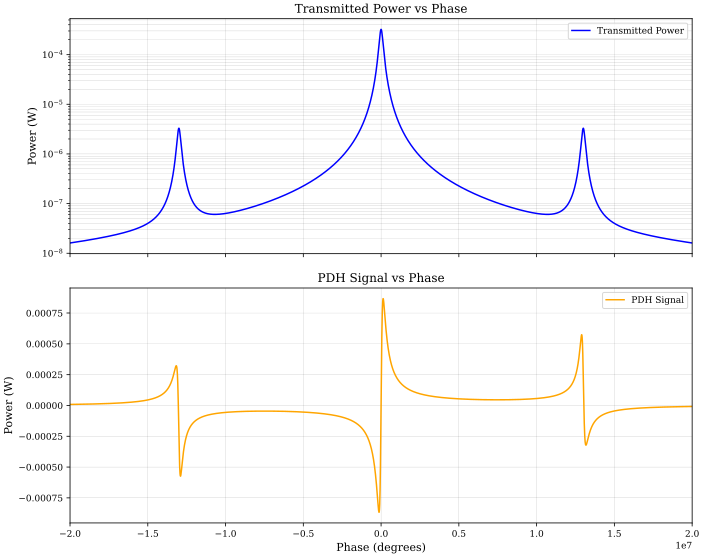

In [65]:
#Then, we simply scan the laser's frequency and look at the output of the demodulation PD
out = eom_model.run(fac.Xaxis(LASER.f,'lin', -20e6, 20e6, 5000))
x_axis=out.x1
pdtrans=out['pdtrans']
PDH_signal_I=(out['pdh_pd'])
pdrefl=out['pdrefl']
# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].semilogy(x_axis, pdtrans, label='Transmitted Power')
axs[0].set_ylabel('Power (W)')
axs[0].set_title('Transmitted Power vs Phase')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(x_axis, 5*PDH_signal_I, label='PDH Signal', color='orange')
axs[1].set_xlabel('Phase (degrees)')
axs[1].set_ylabel('Power (W)')
axs[1].set_title('PDH Signal vs Phase')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### 📡 Simulating the Cavity Pole with a Broadband Amplitude-Modulated EOM

This section demonstrates how to simulate the **pole frequency** of a cavity using Finesse 3 and a demodulated power detector. We apply amplitude modulation (AM) to the input light and sweep the laser frequency, observing the transmitted signal.

#### 🔧 Procedure:

1. Copy the base model (`pole_code = eom_model.deepcopy()`).
2. Set the **EOM** to amplitude modulation (`mod_type = 'am'`) and give it a small modulation index (`midx = 0.05`). You can access a component keyword in this syntax model.component_name.keyword = value/string
3. Add a `PowerDetectorDemod1` on the **transmitted port** of the cavity (after mirror M2).
4. Sweep the **EOM frequency** (think about the range you want to scan this).
5. Compute and plot the **magnitude and phase** of the demodulated transmission.
6. Compare the simulated result to the analytically computed **cavity pole frequency**.



